In [22]:
import numpy as np
import pandas as pd
import cPickle as pkl
import linearcorex
from matplotlib import pyplot as plt

# Load Stock Data

In [23]:
def load_data():
    with open('../data/EOD_week.pkl', 'rb') as f:
        df = pd.DataFrame(pkl.load(f))
    return df

In [24]:
df = load_data()
print("Data.shape = {}".format(df.shape))

Data.shape = (887, 5038)


# Train linear corex for single window

In [40]:
corex = linearcorex.Corex(n_hidden=4,
                        max_iter=50,
                        tol=1e-5,
                        anneal=True,
                        missing_values=None,
                        discourage_overlap=True,
                        gaussianize='standard',
                        gpu=False,
                        verbose=True,
                        seed=None)

Linear CorEx with 4 latent factors


In [41]:
corex.fit(df)

28 iterations to tol: 0.000010
10 iterations to tol: 0.000010
6 iterations to tol: 0.000010


In [6]:
corex.ws

array([[-0.   , -0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       [ 0.003,  0.002, -0.   , ...,  0.001,  0.001,  0.   ],
       [-0.   ,  0.   , -0.001, ..., -0.   , -0.002,  0.   ],
       [ 0.001,  0.   , -0.003, ..., -0.   , -0.   , -0.001]], dtype=float32)

In [7]:
corex.tc

1122.0017700195312

## Covariance Matrix 

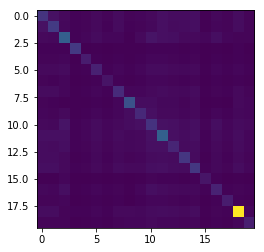

In [8]:
cov = corex.get_covariance()
plt.imshow(cov[:20, :20])
plt.show()

## Mutual Informations

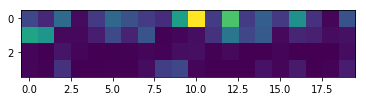

In [9]:
mis = corex.mis
plt.imshow(mis[:, :20])
plt.show()

In [10]:
def get_parent(corex, i):
    """Get parent of `xi` in a learned CorEx model"""
    return np.argmax(corex.mis[:, i])

### print parents

In [11]:
print([get_parent(corex, i) for i in range(20)])

[1, 1, 0, 0, 0, 0, 0, 1, 3, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0]


## Try to get right order of hidden factors

In [12]:
def match_order(A, B):
    """ Given two instances of CorEx: A and B, this function tries
    to reorder hidden factors for B to match the order of hidden 
    factors of A.
    Each hidden factor of B is matched to some hidden factor of B
    with which they have the most children overlap.
    
    NOTE: is this precise enough ?
    """

    used = [False] * A.m
    btoa = [None] * A.m # mapping from B to A
    
    cnt_match = np.zeros((A.m, B.m))
    for x in range(A.nv):
        ai = get_parent(A, x)
        bj = get_parent(B, x)
        cnt_match[ai, bj] += 1
    
    for j in range(B.m):
        best = None
        best_overlap = None
        for i in range(A.m):
            if used[i]:
                continue
            cur_overlap = cnt_match[i, j]
            if (best_overlap is None) or (cur_overlap > best_overlap):
                best = i
                best_overlap = cur_overlap
        
        assert best is not None
        used[best] = True
        btoa[j] = best
    
    return btoa

# Train 2 different corexes on different time windows

In [34]:
start_A = 0
end_A = 200
start_B = 20
end_B = 220

XA = df[start_A:end_A]
XB = df[start_B:end_B]

corex_params = {
    'n_hidden':10,
    'max_iter':50,
    'tol':1e-5,
    'anneal':True,
    'missing_values':None,
    'discourage_overlap':True,
    'gaussianize':'standard',
    'gpu':False,
    'verbose':True,
    'seed':None
}

In [35]:
A = linearcorex.Corex(**corex_params)
B = linearcorex.Corex(**corex_params)

Linear CorEx with 10 latent factors
Linear CorEx with 10 latent factors


In [36]:
A.fit(XA)

In [37]:
B.fit(XB)

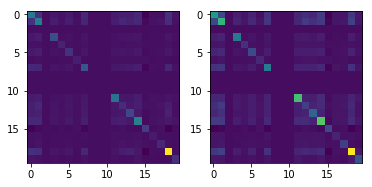

In [30]:
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(A.get_covariance()[:20, :20])
ax[1].imshow(B.get_covariance()[:20, :20])
plt.show()

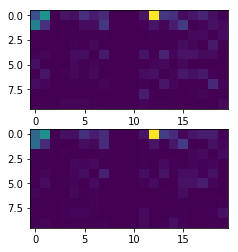

In [31]:
fig, ax = plt.subplots(nrows=2)
ax[0].imshow(A.mis[:, :20])
ax[1].imshow(B.mis[:, :20])
plt.show()

### try match hiddens

In [19]:
btoa = match_order(A,B)

NameError: name 'match_order' is not defined

In [ ]:
fig, ax = plt.subplots(nrows=2)
ax[0].imshow(A.mis[:, :20])
ax[1].imshow(B.mis[btoa, :20])
plt.show()

### TCs

In [38]:
A.tc

650.76292991638184

In [39]:
B.tc

671.10610961914062

TODO:
    a. create copy of linear corex in linear corex library
    b. add L1, L2 regularizations on differences of Ws and add to objective function
        I guess this is the most basic type of regularization we can add
        Calculate second order gradients to allow to use Quasi Newton optmization
    c. Introduce some metrics to understand if the regularization changes something
        Good starting point for this is the paper Aram mentioned: Time-varying network inference via graphical lasso
        
NOTE:
    a. in corex objective we they calculate H(Zj) the write 1/2 * log(E[zj^2]) but it should be log(E[zj]^2 - E[zj^2])